# Ontology Graph Embedding by StellarGraph and Alingmment by OT 

In [602]:
# import libraries
import pandas as pd
import numpy as np
import scipy as sp
import json

from rdflib import Graph, URIRef, RDFS
from gensim.models.fasttext import FastText
from gensim.models.fasttext import load_facebook_model
from gensim.models.fasttext import load_facebook_vectors

import corpus_build_utils
from corpus_build_utils import clean_document_lower
from AlignmentFormat import serialize_mapping_to_tmp_file

import sys
import logging
from collections import defaultdict

import jellyfish
import ot

from xml.dom import minidom
from nltk.corpus import wordnet

import importlib

import matplotlib.pyplot as plt
%matplotlib inline

from stellargraph import StellarGraph
import OTMapOnto as maponto

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("logging info test")

INFO:root:logging info test


# Load pre-trained Fasttext embeddings

In [273]:
importlib.reload(maponto)

<module 'OTMapOnto' from '/Users/yan/Google Drive/ontology-mapping/src/OTMapOnto.py'>

In [ ]:
%%time
model_path="../data/crawl-300d-2M-subword.bin"
embs_model = maponto.load_embeddings(model_path, embs_model)

# Load the Source and Target RDF Graphs

In [267]:
src_url = "../data/mouse.owl"
tgt_url = "../data/human.owl"
src_graph = Graph().parse(src_url)
tgt_graph = Graph().parse(tgt_url)

In [268]:
refs_url = "../data/reference.rdf"

In [1209]:
%%time
results = maponto.match_evaluate(src_graph, tgt_graph, embs_model, refs_url, maponto.make_mappings_nn, None, \
                                 'label', 'weighted', None)

INFO:root:The number of level_1 predicted matchings is 951
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 32
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (1757, 2315)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 920


Total number of references is 1516
Total correctly predicted alignments is 1230
Total number of predicted is 1903
Precision is 0.6463478717813977
Recall is 0.8113456464379947
F1-Measure is 0.7195086282538753
CPU times: user 21.8 s, sys: 1.4 s, total: 23.2 s
Wall time: 10.7 s


# Make StellarGraph from RDF Graph
1. extract concept labels from RDF graph
2. assign ids to each concept node
3. extract a relation graph from RDF graph, i.e., relation graph has edges corresponding to subClassOf and various relations
4. extract label embeddings as node features. When extracting label embeddings, first check whether the label is in the pre-trained model, if it is not, break the label into individual words then take the average of the individual word embeddings.
5. build a StellarGraph from the nodes and edges

In [274]:
# embed a clndLabel
def emb_concept_clndLabel(clndLabel, embs_model):
    """
        input: clndLabel: a cleaned concept label string by " ".join(clean_document_lower(x))
               embs_mode: pre-trained word embedding model
        output: a d-dimensional embedding of the clndLabel
    """
  
    if clndLabel in embs_model.wv.key_to_index:
        
        return embs_model.wv[clndLabel]
    
    else:
        embs = []
        for z in clndLabel.split():
            embs.append(embs_model.wv[z])
    
        return np.array(embs).mean(0)


In [275]:
embs_model.wv['cubiti'].shape

(300,)

In [276]:
'cubiti' in embs_model.wv.key_to_index

False

In [277]:
'articulatio' in embs_model.wv.key_to_index

True

In [278]:
# make a DataFrame of concept nodes with embeddings as features; each node identified by its uri
def node_features_from_clndLabel_embeddings(label_clnd_uris, embs_model, dim):
    """
        input: label_clnd_uri: DataFrame 'label', 'uri', 'clndLabel'
               embs_model: pre-trained embedding model
               dim: the dimension of the word embeddings
        output: DataFrame with index=uri and features 'd1', 'd2', ...'d300'
    """
    
    # for each clndLabel, retrieve a dim dimensional embedding.
    # the apply() gets a Series of embedding arrays
    embs_array = label_clnd_uris.clndLabel.apply(lambda x: emb_concept_clndLabel(x, embs_model))
    
    # make the column names for the dimensions of an embedding
    embs_cols = ['d' + str(i) for i in np.arange(dim)]

    # conver the Series of embedding arrays to a DataFrame;
    # assign the column names to the embedding dimensions
    embs_df = pd.DataFrame(dict(zip(embs_array.index, embs_array.values)), index = embs_cols).T
    
    # concanate the embeddings to ['label', 'uri', 'clndLabel']
    label_clnd_uri_embs = pd.concat([label_clnd_uris, embs_df], axis = 1)
    
    # drop the ['label', 'clndLabel'] columns and set the uri as index
    return label_clnd_uri_embs.drop(['label', 'clndLabel'], axis=1).set_index('uri')

In [279]:
# build a stellargraph with node label embeddings from an RDF graph and pre-trained embedding model
def stellar_from_rdf(rdfGraph, embs_model, dim):
    """
        input: rdfGraph: an RDF graph parsed from an owl file by rdflib
               embs_model: pre-trained word embedding model
               dim: embedding dimension
        output: a StellarGraph with node features correpsonding to the label embeddings in the RDF graph
    """
    
    # build relation graph from the RDF graph
    relGraph = maponto.build_relation_graph(rdfGraph)
    
    # extract embeddings for concept nodes
    label_uris = maponto.extract_label_uris(rdfGraph)
    label_clnd_uris = maponto.clean_labels(label_uris)
    concept_node_embeddings = node_features_from_clndLabel_embeddings(label_clnd_uris, embs_model, dim)
    
    #get the prefix of the RDF
    prefix = maponto.get_prefix_rdfgraph(rdfGraph).toPython()
    
    if(prefix == 'http://mouse.owl#'):
        # remove the edges to http://www.w3.org/2002/07/owl#Thing
        relGraph = relGraph[relGraph.object.str.contains('http://www.w3.org/2002/07/owl#Thing') == False]
    if(prefix == 'http://human.owl#'):
        # remove the edges to Anatomic_Structure_System_or_Substance http://human.owl#NCI_C12219
        relGraph = relGraph[relGraph.object.str.contains('http://human.owl#NCI_C12219')]
    
    stellarG = StellarGraph(concept_node_embeddings, relGraph, source_column='subject', target_column='object', 
                            node_type_default='concept', edge_type_column='predicate')

    return stellarG

In [584]:
srelGraph = maponto.build_relation_graph(src_graph)

INFO:root:Building a relation graph from the given RDF triple graph...


In [586]:
sstellarG = StellarGraph(edges=srelGraph, source_column='subject', target_column='object', 
                            node_type_default='concept', edge_type_column='predicate')

In [588]:
print(sstellarG.info())

StellarGraph: Undirected multigraph
 Nodes: 2738, Edges: 4493

 Node types:
  concept: [2738]
    Features: none
    Edge types: concept-http://mouse.owl#UNDEFINED_part_of->concept, concept-rdfs:subClassOf->concept

 Edge types:
    concept-rdfs:subClassOf->concept: [2856]
        Weights: all 1 (default)
        Features: none
    concept-http://mouse.owl#UNDEFINED_part_of->concept: [1637]
        Weights: all 1 (default)
        Features: none


In [589]:
# build a stellargraph without node label embeddings from an RDF graph
def stellar_from_rdf_edges(rdfGraph):
    """
        input: rdfGraph: an RDF graph parsed from an owl file by rdflib
        output: a StellarGraph corresponding to the relation edges in the RDF graph
    """
    
    # build relation graph from the RDF graph
    relGraph = maponto.build_relation_graph(rdfGraph)
    
    stellarG = StellarGraph(edges=relGraph, source_column='subject', target_column='object', 
                            node_type_default='concept', edge_type_column='predicate')

    return stellarG

In [590]:
sstellar = stellar_from_rdf(src_graph, embs_model, 300)
sstellar_edges = stellar_from_rdf_edges(src_graph)

INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...


In [450]:
print(sstellar.info())

StellarGraph: Undirected multigraph
 Nodes: 2737, Edges: 3444

 Node types:
  concept: [2737]
    Features: float32 vector, length 300
    Edge types: concept-http://mouse.owl#UNDEFINED_part_of->concept, concept-rdfs:subClassOf->concept

 Edge types:
    concept-rdfs:subClassOf->concept: [1807]
        Weights: all 1 (default)
        Features: none
    concept-http://mouse.owl#UNDEFINED_part_of->concept: [1637]
        Weights: all 1 (default)
        Features: none


In [592]:
tstellar = stellar_from_rdf(tgt_graph, embs_model, 300)
tstellar_edges = stellar_from_rdf_edges(tgt_graph)

INFO:root:Building a relation graph from the given RDF triple graph...
INFO:root:Building a relation graph from the given RDF triple graph...


In [451]:
print(tstellar.info())

StellarGraph: Undirected multigraph
 Nodes: 3298, Edges: 5415

 Node types:
  concept: [3298]
    Features: float32 vector, length 300
    Edge types: concept-http://human.owl#UNDEFINED_part_of->concept, concept-rdfs:subClassOf->concept

 Edge types:
    concept-rdfs:subClassOf->concept: [3753]
        Weights: all 1 (default)
        Features: none
    concept-http://human.owl#UNDEFINED_part_of->concept: [1662]
        Weights: all 1 (default)
        Features: none


# Apply GNN to the StellarGraphs of the Ontologies to Get Concept Node Embeddings

In [280]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

In [593]:
sstellar.nodes().shape, tstellar.nodes().shape, sstellar_edges.nodes().shape, tstellar_edges.nodes().shape

((2737,), (3298,), (2738,), (3298,))

In [526]:
len(sstellar.edges())

3444

In [579]:
# GNN embedding on an ontology graph
def gnn_embeddings_infomax(stellargraph, emb_dims, activations, epochs):
    """
        input: stellargraph, a stellarGraph created from an ontology graph
               emb_dims: the list of dimensions of the base GCN layers
               activations: the list of activtions corresponding to the GCN layers
               epoch: number of training epochs
        output: a DataFrame with the index corresponding to stellargraph.nodes and other columns corresponding to embeddings
    """
    fullbatch_generator = FullBatchNodeGenerator(stellargraph, sparse=False)
    
    # base GCN model with one layer in emb_dim
    gcn_model = GCN(layer_sizes=emb_dims, activations=activations, generator=fullbatch_generator)
    
    corrupted_generator = CorruptedGenerator(fullbatch_generator)
    gen = corrupted_generator.flow(stellargraph.nodes())
    
    infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
    x_in, x_out = infomax.in_out_tensors()
    
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(learning_rate=1e-3))
    
    logging.info("Fitting the GNN on the ontology graph...")
    es=EarlyStopping(monitor='loss', min_delta=0, patience=20)
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
    
    x_emb_in, x_emb_out = gcn_model.in_out_tensors()
    x_out = tf.squeeze(x_emb_out, axis=0)
    emb_model = Model(inputs=x_emb_in, outputs=x_out)
    
    all_embeddings = emb_model.predict(fullbatch_generator.flow(stellargraph.nodes()))
    
    all_embeddings_df = pd.DataFrame(all_embeddings, index=stellargraph.nodes())
    
    return all_embeddings_df

In [580]:
sgnn_embeddings = gnn_embeddings_infomax(sstellar, [300], ['relu'], 300)

INFO:root:Fitting the GNN on the ontology graph...


Using GCN (local pooling) filters...


In [581]:
tgnn_embeddings = gnn_embeddings_infomax(tstellar, [300], ['relu'], 300)

Using GCN (local pooling) filters...


INFO:root:Fitting the GNN on the ontology graph...


In [594]:
sedges_gnn_embeddings = gnn_embeddings_infomax(sstellar_edges, [300], ['relu'], 300)

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning

# Apply OT to GNN Embeddings

In [549]:
costs = sp.spatial.distance.cdist(sgnn_embeddings, tgnn_embeddings)

In [550]:
costs.max(), costs.min()

(7.004706311983358, 0.4161979408225855)

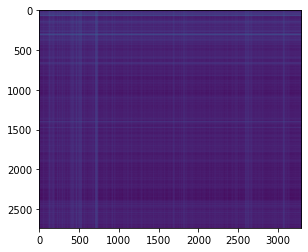

In [551]:
plt.imshow(costs)

In [552]:
costs_norm = costs/costs.max()

In [553]:
costs_norm.shape

(2737, 3298)

In [554]:
couplings = maponto.ot_couplings(sconcept_node_embeddings.shape[0], tconcept_node_embeddings.shape[0], costs_norm)

INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...


In [555]:
couplings.max(), couplings.min()

(0.00030321406913280777, 0.0)

In [556]:
align = maponto.make_mappings_nn(slabel_clnd_uris, tlabel_clnd_uris, couplings)

INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...


In [557]:
refs_url = "../data/reference.rdf"
maponto.evaluate(align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 2
Total number of predicted is 2003
Precision is 0.000998502246630055
Recall is 0.0013192612137203166
F1-Measure is 0.0011366865586814436


# Visualize the Label Embeddings

In [378]:
# extract embeddings for concept nodes
slabel_uris = maponto.extract_label_uris(src_graph)
slabel_clnd_uris = maponto.clean_labels(slabel_uris)
sconcept_node_embeddings = node_features_from_clndLabel_embeddings(slabel_clnd_uris, embs_model, dim)

In [379]:
# extract embeddings for concept nodes
tlabel_uris = maponto.extract_label_uris(tgt_graph)
tlabel_clnd_uris = maponto.clean_labels(tlabel_uris)
tconcept_node_embeddings = node_features_from_clndLabel_embeddings(tlabel_clnd_uris, embs_model, dim)

In [337]:
sconcept_node_embeddings.shape

(2737, 300)

In [338]:
trans = TSNE(n_components=2)
semb_transformed = trans.fit_transform(sconcept_node_embeddings)

In [340]:
semb_transformed.shape

(2737, 2)

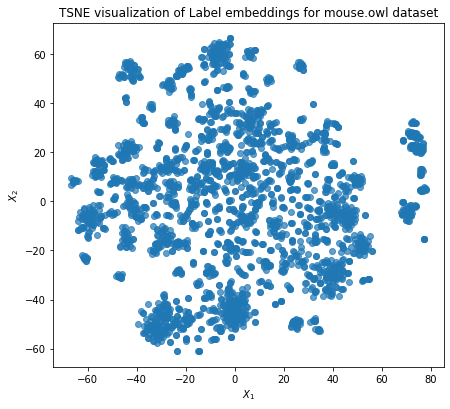

In [342]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    semb_transformed[:, 0],
    semb_transformed[:, 1],
    #c=emb_transformed["label"].cat.codes,
    #cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of Label embeddings for mouse.owl dataset")
plt.show()

In [441]:
label_costs = sp.spatial.distance.cdist(sconcept_node_embeddings, tconcept_node_embeddings)

In [442]:
label_costs.max(), label_costs.min()

(2.2499771795929724, 0.0)

In [444]:
label_costs_norm = label_costs/label_costs.max()

In [558]:
label_costs_norm.shape

(2737, 3298)

In [561]:
label_couplings = maponto.ot_couplings(sconcept_node_embeddings.shape[0], tconcept_node_embeddings.shape[0], label_costs_norm)

INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...


In [562]:
label_couplings.max(), label_couplings.min()

(0.0003653635367190354, 0.0)

In [563]:
label_align = maponto.make_mappings_nn(slabel_clnd_uris, tlabel_clnd_uris, label_couplings)

INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...


In [564]:
refs_url = "../data/reference.rdf"
maponto.evaluate(label_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 1190
Total number of predicted is 1643
Precision is 0.7242848447961047
Recall is 0.7849604221635884
F1-Measure is 0.7534029756251979


In [565]:
# extract the concepts that are not matched by labels
slabel_clnd_uris_notOTMtc = slabel_clnd_uris[slabel_clnd_uris.uri.isin(label_align.source)==False].\
    reset_index(drop=True)
tlabel_clnd_uris_notOTMtc = tlabel_clnd_uris[tlabel_clnd_uris.uri.isin(label_align.target)==False].\
    reset_index(drop=True)

In [568]:
slabel_clnd_uris_notOTMtc.shape, tlabel_clnd_uris_notOTMtc.shape

((1094, 3), (1655, 3))

In [575]:
match_labels_df = maponto.match_concept_labels(slabel_clnd_uris_notOTMtc, tlabel_clnd_uris_notOTMtc, None)
match_labels_df.shape

(6, 4)

In [571]:
maponto.evaluate(match_labels_df, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 6
Total number of predicted is 6
Precision is 1.0
Recall is 0.00395778364116095
F1-Measure is 0.007884362680683312


In [572]:
# extract the concepts that are not matched by labels
slabel_clnd_uris_notLabMtc = slabel_clnd_uris_notOTMtc[slabel_clnd_uris_notOTMtc.uri.isin(match_labels_df.source)==False].\
    reset_index(drop=True)
tlabel_clnd_uris_notLabMtc = tlabel_clnd_uris_notOTMtc[tlabel_clnd_uris_notOTMtc.uri.isin(match_labels_df.target)==False].\
    reset_index(drop=True)

In [573]:
slabel_clnd_uris_notLabMtc.shape, tlabel_clnd_uris_notLabMtc.shape

((1090, 3), (1649, 3))

In [576]:
match_syn_df = maponto.match_label_synonyms(slabel_clnd_uris_notLabMtc, tlabel_clnd_uris_notLabMtc, None)
match_syn_df.shape

INFO:root:Retrieving Synsets by WordNet...


(12, 4)

In [595]:
maponto.evaluate(match_syn_df, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 10
Total number of predicted is 12
Precision is 0.8333333333333334
Recall is 0.006596306068601583
F1-Measure is 0.013089005235602096


# OT on the concept pairs that meet the subclass-branch constraints under anchor matchings

In [631]:
importlib.reload(maponto)

<module 'OTMapOnto' from '/Users/yan/Google Drive/ontology-mapping/src/OTMapOnto.py'>

In [632]:
importlib.reload(corpus_build_utils)

<module 'corpus_build_utils' from '/Users/yan/Google Drive/ontology-mapping/src/corpus_build_utils.py'>

In [633]:
slabel_uris = maponto.extract_label_uris(src_graph)
tlabel_uris = maponto.extract_label_uris(tgt_graph)

In [634]:
slabel_clnd_uris = maponto.clean_labels(slabel_uris, rmStopWords=True)
tlabel_clnd_uris = maponto.clean_labels(tlabel_uris, rmStopWords=True)

In [635]:
label_align = maponto.match_concept_labels(slabel_clnd_uris, tlabel_clnd_uris, None)
label_align.shape

(951, 4)

In [637]:
label_align.head()

,source,source_label,target,target_label
0,http://mouse.owl#MA_0000003,organ system,http://human.owl#NCI_C12919,Organ_System
1,http://mouse.owl#MA_0000004,trunk,http://human.owl#NCI_C33816,Trunk
2,http://mouse.owl#MA_0000006,head/neck,http://human.owl#NCI_C12418,Head_and_Neck
3,http://mouse.owl#MA_0000007,limb,http://human.owl#NCI_C12429,Limb
4,http://mouse.owl#MA_0000009,adipose tissue,http://human.owl#NCI_C12472,Adipose_Tissue


In [636]:
maponto.evaluate(label_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 948
Total number of predicted is 951
Precision is 0.9968454258675079
Recall is 0.6253298153034301
F1-Measure is 0.7685447912444265


In [694]:
# get concepts that are not matched by labels
# extract the concepts that are not matched by labels
slabel_clnd_uris_notLabMtc = slabel_clnd_uris[slabel_clnd_uris.uri.isin(label_align.source)==False].\
    reset_index(drop=True)
tlabel_clnd_uris_notLabMtc = tlabel_clnd_uris[tlabel_clnd_uris.uri.isin(label_align.target)==False].\
    reset_index(drop=True)

In [695]:
slabel_clnd_uris_notLabMtc.shape, tlabel_clnd_uris_notLabMtc.shape

((1788, 3), (2347, 3))

In [696]:
slabel_clnd_uris_notLabMtc.head()

,label,uri,clndLabel
0,mouse anatomy,http://mouse.owl#MA_0000001,mouse anatomy
1,spinal cord grey matter,http://mouse.owl#MA_0000002,spinal cord grey matter
2,body cavity/lining,http://mouse.owl#MA_0000005,body cavity lining
3,tail,http://mouse.owl#MA_0000008,tail
4,hemolymphoid system,http://mouse.owl#MA_0000013,hemolymphoid system


In [697]:
tlabel_clnd_uris_notLabMtc.head()

,label,uri,clndLabel
0,Anatomic_Structure_System_or_Substance,http://human.owl#NCI_C12219,anatomic structure system substance
1,External_Upper_Lip,http://human.owl#NCI_C12221,external upper lip
2,External_Lower_Lip,http://human.owl#NCI_C12222,external lower lip
3,External_Lip,http://human.owl#NCI_C12223,external lip
4,Mucosa_of_the_Upper_Lip,http://human.owl#NCI_C12224,mucosa upper lip


In [724]:
# make a cost matrix -> DataFrame with rows and columns indexed by corresponding uris
costs_arr = np.ones((slabel_clnd_uris_notLabMtc.shape[0], tlabel_clnd_uris_notLabMtc.shape[0])) * 9999
costs_arr.shape

(1788, 2347)

In [725]:
costs_df = pd.DataFrame(costs_arr, index=slabel_clnd_uris_notLabMtc.uri, columns=tlabel_clnd_uris_notLabMtc.uri)
costs_df.shape

(1788, 2347)

In [726]:
costs_df.head()

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000002,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000005,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000008,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000013,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0


In [727]:
# test: change a cell value to 0.001
costs_df.loc['http://mouse.owl#MA_0000005', 'http://human.owl#NCI_C12221'] = 9999
costs_df.head()

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000002,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000005,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000008,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0
http://mouse.owl#MA_0000013,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,...,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0


In [728]:
costs_df_norm = costs_df/costs_df.max()
costs_df_norm.head()

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000008,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Test SPARQL query on rdfs:subClassOf Hierarchy

In [682]:
prefix = maponto.get_prefix_rdfgraph(src_graph)

In [690]:
clsId = 'http://mouse.owl#MA_0000011'.replace(prefix, '')

In [691]:
q = 'select ?sub where {?sub (rdfs:subClassOf)+ :' + clsId + '}'

In [693]:
res = src_graph.query(q)
for item in res:
    print(item[0])

http://mouse.owl#MA_0000009
http://mouse.owl#MA_0000697
http://mouse.owl#MA_0000698
http://mouse.owl#MA_0000114
http://mouse.owl#MA_0000110
http://mouse.owl#MA_0000104
http://mouse.owl#MA_0000106
http://mouse.owl#MA_0001857
http://mouse.owl#MA_0001883
http://mouse.owl#MA_0001884
http://mouse.owl#MA_0001758
http://mouse.owl#MA_0001762
http://mouse.owl#MA_0001759
http://mouse.owl#MA_0001764
http://mouse.owl#MA_0001763
http://mouse.owl#MA_0000107
http://mouse.owl#MA_0000485
http://mouse.owl#MA_0001886
http://mouse.owl#MA_0001885
http://mouse.owl#MA_0001760
http://mouse.owl#MA_0000109
http://mouse.owl#MA_0000487
http://mouse.owl#MA_0001761
http://mouse.owl#MA_0000105
http://mouse.owl#MA_0000108
http://mouse.owl#MA_0000486
http://mouse.owl#MA_0000513
http://mouse.owl#MA_0000495
http://mouse.owl#MA_0000507
http://mouse.owl#MA_0000501
http://mouse.owl#MA_0000526
http://mouse.owl#MA_0000533
http://mouse.owl#MA_0000519
http://mouse.owl#MA_0000560
http://mouse.owl#MA_0000555
http://mouse.owl#MA_

In [733]:
res = src_graph.query("select ?sub ?obj where {?sub rdfs:subClassOf ?obj . filter(!isBlank(?sub)). filter(!isBlank(?obj))}")
print(len(res))

2856


# Interva Labeling and Retrieving Nodes between Mappings

In [734]:
# Create the hierarchical graph and computer interval labeling numbers
import networkx as nx

In [832]:
graph = nx.DiGraph()

In [833]:
graph.add_edge('http://mouse.owl#MA_0000001', 'http://mouse.owl#MA_0000002')
graph.add_edge('http://mouse.owl#MA_0000001', 'http://mouse.owl#MA_0000003')
graph.add_edge('http://mouse.owl#MA_0000002', 'http://mouse.owl#MA_0000004')
graph.add_edge('http://mouse.owl#MA_0000003', 'http://mouse.owl#MA_0000005')
graph.add_edge('http://mouse.owl#MA_0000004', 'http://mouse.owl#MA_0000006')
graph.add_edge('http://mouse.owl#MA_0000004', 'http://mouse.owl#MA_0000007')
graph.add_edge('http://mouse.owl#MA_0000005', 'http://mouse.owl#MA_0000008')
graph.add_edge('http://mouse.owl#MA_0000006', 'http://mouse.owl#MA_0000009')
graph.add_edge('http://mouse.owl#MA_0000006', 'http://mouse.owl#MA_00000010')

In [834]:
graph.edges()

OutEdgeView([('http://mouse.owl#MA_0000001', 'http://mouse.owl#MA_0000002'), ('http://mouse.owl#MA_0000001', 'http://mouse.owl#MA_0000003'), ('http://mouse.owl#MA_0000002', 'http://mouse.owl#MA_0000004'), ('http://mouse.owl#MA_0000003', 'http://mouse.owl#MA_0000005'), ('http://mouse.owl#MA_0000004', 'http://mouse.owl#MA_0000006'), ('http://mouse.owl#MA_0000004', 'http://mouse.owl#MA_0000007'), ('http://mouse.owl#MA_0000005', 'http://mouse.owl#MA_0000008'), ('http://mouse.owl#MA_0000006', 'http://mouse.owl#MA_0000009'), ('http://mouse.owl#MA_0000006', 'http://mouse.owl#MA_00000010')])

In [919]:
# retrieve the DFS preorders and initial maxpre of all leaves
def get_preorders(graph, source=None):
    """
        input: graph
        output: a DataFrame indexed by the graph nodes with columns ['preorder']
                where 'preorder' are nodes' DFS preorder number
    """
    pre_orders = []
    order = 1
    if source == None:
        pre = list(nx.dfs_preorder_nodes(graph))
    else:
        pre = list(nx.dfs_preorder_nodes(graph, source))
    for n in pre:
        pre_orders.append(order)
        order = order + 1
        
    return pd.DataFrame(pre_orders, columns=['preorder'], index=list(pre))

In [926]:
pre_df = get_preorders(graph, 'http://mouse.owl#MA_0000006') 
pre_df

,preorder
http://mouse.owl#MA_0000006,1
http://mouse.owl#MA_0000009,2
http://mouse.owl#MA_00000010,3


In [872]:
pre_df['maxpre'] = pre_df.preorder
pre_df

,preorder,maxpre
http://mouse.owl#MA_0000001,1,1
http://mouse.owl#MA_0000002,2,2
http://mouse.owl#MA_0000004,3,3
http://mouse.owl#MA_0000006,4,4
http://mouse.owl#MA_0000009,5,5
http://mouse.owl#MA_00000010,6,6
http://mouse.owl#MA_0000007,7,7
http://mouse.owl#MA_0000003,8,8
http://mouse.owl#MA_0000005,9,9
http://mouse.owl#MA_0000008,10,10


In [873]:
pre_df.maxpre['http://mouse.owl#MA_0000005']

9

In [922]:
# given the current maxpres and a list of successors, find the largest maxpre
def update_maxpre(maxpre, successors):
    """
        input: mappre: a pandas Series with current maxpre; indexed by nodes
               successors: a list of nodes that are the DFS successors of the calling node
        output: newMaxpre: the largest maxpre among the successors
    """
    # initialize the maxpre with an impossible small value
    max = -1
    for i in range(len(successors)):
        if maxpre[successors[i]] > max:
            max = maxpre[successors[i]]
    
    return max

In [1009]:
# get the roots and standalone class nodes in an RDF graph
import rdflib
from rdflib import util
def get_roots_standalones(rdfgraph):
    """
        input: rdfgraph: an RDF graph
        output: a list of roots of rdfs:subClassOf hierarchies and standalone nodes
    """
    roots = []
    for nv in util.find_roots(rdfgraph, rdflib.RDFS.subClassOf):
        if type(nv) != rdflib.term.BNode:
            roots.append(nv.toPython())
    
    if (len(roots) == 1):
        return roots
    else:
        res = rdfgraph.query(
            """
                select ?c 
                where {
                    ?c a owl:Class . 
                    filter(!isBlank(?c)) . 
                    filter not exists{?c rdfs:subClassOf ?o} . 
                    filter not exists{?o rdfs:subClassOf ?c} 
                }
            """
        )
        for item in res:
            roots.append(item[0].toPython())

        return roots

In [1013]:
get_roots_standalones(cmt_graph)

['http://www.w3.org/2002/07/owl#Thing',
 'http://cmt#Decision',
 'http://cmt#Document',
 'http://cmt#Person',
 'http://cmt#ProgramCommittee',
 'http://cmt#Bid',
 'http://cmt#Preference',
 'http://cmt#SubjectArea']

In [1033]:
# get the interval labeling for the graph
import rdflib
from rdflib import util
def interval_labeling(rdfgraph, source=None):
    """
        input: rdfgraph: a RDF graph for interval labeling on its rdfs:subClassOf hierarchy
        output: DataFrame indexed by nodes with ['pre', 'maxpre'] for nodes to their (pre_order, maxpre) of interval labeling
    """
    
    logging.info("Computing the intervel labeling numbers for rdfs:subClassOf hierarchy...")
    
    # convert to a networkx graph
    logging.info("Building rdfs:subClassOf hierarchical graph....")
    edges = rdfgraph.query("select ?sub ?obj where {?sub rdfs:subClassOf ?obj . filter(!isBlank(?sub)). filter(!isBlank(?obj))}")
    graph = nx.DiGraph()
    for e in edges:
        graph.add_edge(e[1].toPython(), e[0].toPython())
     

    if source != None:
        pre_maxpre_df = get_preorders(graph, source)
    else:
        # find the roots of the RDF subClassOf hierarchy
        roots = get_roots_standalones(rdfgraph)
        if (len(roots) == 1):
            root = roots[0]
        else:
            # add edges from 'http://www.w3.org/2002/07/owl#Thing' to all roots and standalone nodes
            root = 'http://www.w3.org/2002/07/owl#Thing'
            for anode in roots:
                if anode != root:
                    graph.add_edge(root, anode)
        pre_maxpre_df = get_preorders(graph, root) 
    
    logging.info("Computing the DFS pre-order numbers...")  
    pre_maxpre_df['maxpre'] = pre_maxpre_df.preorder
    
    # update the maxpres
    if source != None:
        suc = nx.dfs_successors(graph, source)
    else:
        suc = nx.dfs_successors(graph, root)
    
    logging.info("Computing the DFS maximum pre-orders numbers of hierarchical descendants....")
    change = True
    while change:
        change = False
        for n in suc:
            newMaxpre = update_maxpre(pre_maxpre_df.maxpre, suc[n])
            if newMaxpre > pre_maxpre_df.loc[n, 'maxpre']:
                pre_maxpre_df.loc[n, 'maxpre'] = newMaxpre
                change = True
    
    return pre_maxpre_df

In [1093]:
tpre_maxpre_df = interval_labeling(tgt_graph)
tpre_maxpre_df

INFO:root:Computing the intervel labeling numbers for rdfs:subClassOf hierarchy...
INFO:root:Building rdfs:subClassOf hierarchical graph....
INFO:root:Computing the DFS pre-order numbers...
INFO:root:Computing the DFS maximum pre-orders numbers of hierarchical descendants....


,preorder,maxpre
http://human.owl#NCI_C12219,1,3298
http://human.owl#NCI_C21599,2,872
http://human.owl#NCI_C12508,3,417
http://human.owl#NCI_C32725,4,145
http://human.owl#NCI_C43251,5,12
...,...,...
http://human.owl#NCI_C12407,3294,3294
http://human.owl#NCI_C12417,3295,3297
http://human.owl#NCI_C32591,3296,3296
http://human.owl#NCI_C33050,3297,3297


In [1113]:
# given a first node and a list of second nodes, 
# retrieve all nodes between the first and the seconds according to their interval labelings
def get_in_between(first, seconds, interval_labelings):
    """
        input: first: a source node in a directed graph
               seconds: a list of nodes as the targets from the first (source)
               interval_labelings: DataFrame contains the interval labelings of nodes as ('preorder', 'maxpre') indexed by nodes
        output: DataFrame contains a list of nodes between the first and the set of seconds in the hierarchical tree
    """
    #res_index = []
    #res_pre = []
    #res_maxpre = []
    n1_pre = interval_labelings.preorder[first]
    n1_maxpre = interval_labelings.maxpre[first]
    
    '''
    for n in interval_labelings.index:
        pre = interval_labelings.preorder[n]
        maxpre = interval_labelings.maxpre[n]
        # this node is a descendent of n1
        if pre > n1_pre and maxpre <= n1_maxpre:
            # assume to keep this node
            keep = True
            for secn in seconds:
                secn_pre = interval_labelings.preorder[secn]
                secn_maxpre = interval_labelings.maxpre[secn]

                # is the node a descendent of any second node?
                if pre >= secn_pre and maxpre <= secn_maxpre:
                    keep = False
                    break

            if keep:
                res_index.append(n)
                res_pre.append(pre)
                res_maxpre.append(maxpre)
    return pd.DataFrame({'preorder':res_pre, 'maxpre':res_maxpre}, index=res_index)
    '''
    
    # get n1's children
    descendant_pool = interval_labelings[(interval_labelings.preorder > n1_pre) & (interval_labelings.maxpre <= n1_maxpre)]
    
    # for each second, keep those are not second's children
    for secn in seconds:
        secn_pre = interval_labelings.preorder[secn]
        secn_maxpre = interval_labelings.maxpre[secn]
        descendant_pool = descendant_pool[(descendant_pool.preorder < secn_pre) | (descendant_pool.maxpre > secn_maxpre)]
    
    return descendant_pool

In [1098]:
n1 = 'http://www.w3.org/2002/07/owl#Thing'
n2 = 'http://mouse.owl#MA_0000004'

In [1115]:
get_in_between(n1, [n2, 'http://mouse.owl#MA_0000043'], spre_maxpre)

,preorder,maxpre
http://mouse.owl#MA_0001295,2,2
http://mouse.owl#MA_0001238,3,3
http://mouse.owl#MA_0000387,4,4
http://mouse.owl#MA_0000852,6,6
http://mouse.owl#MA_0000767,7,7
...,...,...
http://mouse.owl#MA_0000799,2733,2733
http://mouse.owl#MA_0001679,2734,2734
http://mouse.owl#MA_0000932,2735,2735
http://mouse.owl#MA_0002736,2736,2736


# Build networkx Graphs from the RDF Graphs

In [912]:
src_edges = src_graph.query("select ?sub ?obj where {?sub rdfs:subClassOf ?obj . filter(!isBlank(?sub)). filter(!isBlank(?obj))}")
sgraph = nx.DiGraph()
for e in src_edges:
    sgraph.add_edge(e[1].toPython(), e[0].toPython())

In [947]:
len(sgraph.edges())

2856

In [964]:
import rdflib
from rdflib import util

In [983]:
cmt_url = "../data/conference/cmt.owl"
conference_url = "../data/conference/Conference.owl"
cmt_graph = Graph().parse(cmt_url)
conference_graph = Graph().parse(conference_url)

In [987]:
for n in util.find_roots(cmt_graph, rdflib.RDFS.subClassOf):
    if type(n) != rdflib.term.BNode:
        print(n.toPython())

http://www.w3.org/2002/07/owl#Thing
http://cmt#Decision
http://cmt#Document
http://cmt#Person


In [989]:
cmt_edges = cmt_graph.query("select ?sub ?obj where {?sub rdfs:subClassOf ?obj . filter(!isBlank(?sub)). filter(!isBlank(?obj))}")
cmtgraph = nx.DiGraph()
for e in cmt_edges:
    cmtgraph.add_edge(e[1].toPython(), e[0].toPython())
cmtgraph.edges()

OutEdgeView([('http://cmt#Author', 'http://cmt#Co-author'), ('http://cmt#Author', 'http://cmt#AuthorNotReviewer'), ('http://www.w3.org/2002/07/owl#Thing', 'http://cmt#Conference'), ('http://cmt#User', 'http://cmt#Reviewer'), ('http://cmt#User', 'http://cmt#Administrator'), ('http://cmt#User', 'http://cmt#Author'), ('http://cmt#Reviewer', 'http://cmt#Meta-Reviewer'), ('http://cmt#Person', 'http://cmt#User'), ('http://cmt#Person', 'http://cmt#ConferenceMember'), ('http://cmt#Person', 'http://cmt#ProgramCommitteeMember'), ('http://cmt#Person', 'http://cmt#ExternalReviewer'), ('http://cmt#Person', 'http://cmt#Chairman'), ('http://cmt#ProgramCommitteeMember', 'http://cmt#ProgramCommitteeChair'), ('http://cmt#ConferenceMember', 'http://cmt#AssociatedChair'), ('http://cmt#ConferenceMember', 'http://cmt#ProgramCommitteeMember'), ('http://cmt#ConferenceMember', 'http://cmt#Author'), ('http://cmt#ConferenceMember', 'http://cmt#ConferenceChair'), ('http://cmt#ConferenceMember', 'http://cmt#Review

In [991]:
cmtgraph.add_edge('http://www.w3.org/2002/07/owl#Thing', 'http://cmt#Conference')
cmtgraph.edges()

OutEdgeView([('http://cmt#Author', 'http://cmt#Co-author'), ('http://cmt#Author', 'http://cmt#AuthorNotReviewer'), ('http://www.w3.org/2002/07/owl#Thing', 'http://cmt#Conference'), ('http://cmt#User', 'http://cmt#Reviewer'), ('http://cmt#User', 'http://cmt#Administrator'), ('http://cmt#User', 'http://cmt#Author'), ('http://cmt#Reviewer', 'http://cmt#Meta-Reviewer'), ('http://cmt#Person', 'http://cmt#User'), ('http://cmt#Person', 'http://cmt#ConferenceMember'), ('http://cmt#Person', 'http://cmt#ProgramCommitteeMember'), ('http://cmt#Person', 'http://cmt#ExternalReviewer'), ('http://cmt#Person', 'http://cmt#Chairman'), ('http://cmt#ProgramCommitteeMember', 'http://cmt#ProgramCommitteeChair'), ('http://cmt#ConferenceMember', 'http://cmt#AssociatedChair'), ('http://cmt#ConferenceMember', 'http://cmt#ProgramCommitteeMember'), ('http://cmt#ConferenceMember', 'http://cmt#Author'), ('http://cmt#ConferenceMember', 'http://cmt#ConferenceChair'), ('http://cmt#ConferenceMember', 'http://cmt#Review

In [1001]:
res = conference_graph.query(
    """
        select ?c 
        where {
            ?c a owl:Class . 
            filter(!isBlank(?c)) . 
            filter not exists{?c rdfs:subClassOf ?o} . 
            filter not exists{?o rdfs:subClassOf ?c} 
        }
    """
)
for item in res:
    print(item[0].toPython())

http://conference#Publisher
http://conference#Conference_proceedings
http://conference#Conference_fees
http://conference#Organization
http://conference#Topic
http://conference#Important_dates


In [ ]:
'http://www.w3.org/2002/07/owl#Thing'

# Test on Conferences cmt.owl and Conference.owl

In [1387]:
cmtlabel_uris = maponto.extract_label_uris(cmt_graph)
conferencelabel_uris = maponto.extract_label_uris(conference_graph)

In [1388]:
cmtlabel_clnd_uris = maponto.clean_labels(cmtlabel_uris, rmStopWords=True)
conferencelabel_clnd_uris = maponto.clean_labels(conferencelabel_uris, rmStopWords=True)

In [1389]:
conf_label_align = maponto.match_concept_labels(cmtlabel_clnd_uris, conferencelabel_clnd_uris, None)
conf_label_align.shape

(6, 4)

In [1390]:
conf_label_align.head()

,source,source_label,target,target_label
0,http://cmt#Conference,Conference,http://conference#Conference,Conference
1,http://cmt#Paper,Paper,http://conference#Paper,Paper
2,http://cmt#Person,Person,http://conference#Person,Person
3,http://cmt#ProgramCommittee,ProgramCommittee,http://conference#Program_committee,Program_committee
4,http://cmt#Review,Review,http://conference#Review,Review


In [1393]:
cmt_conf_url = "../data/conference/reference-alignment/cmt-conference.rdf"
maponto.evaluate(conf_label_align, cmt_conf_url)

Total number of references is 15
Total correctly predicted alignments is 4
Total number of predicted is 6
Precision is 0.6666666666666666
Recall is 0.26666666666666666
F1-Measure is 0.38095238095238093


In [1395]:
# get concepts that are not matched by labels
# extract the concepts that are not matched by labels
cmtlabel_clnd_uris_notLabMtc = cmtlabel_clnd_uris[cmtlabel_clnd_uris.uri.isin(conf_label_align.source)==False].\
    reset_index(drop=True)
conferencelabel_clnd_uris_notLabMtc = conferencelabel_clnd_uris[conferencelabel_clnd_uris.uri.isin(conf_label_align.target)==False].\
    reset_index(drop=True)

In [1396]:
cmtlabel_clnd_uris_notLabMtc.shape, conferencelabel_clnd_uris_notLabMtc.shape

((23, 3), (53, 3))

In [1397]:
cmtlabel_clnd_uris_notLabMtc.head()

,label,uri,clndLabel
0,Acceptance,http://cmt#Acceptance,acceptance
1,Administrator,http://cmt#Administrator,administrator
2,AssociatedChair,http://cmt#AssociatedChair,associated chair
3,Author,http://cmt#Author,author
4,AuthorNotReviewer,http://cmt#AuthorNotReviewer,author reviewer


In [1398]:
conferencelabel_clnd_uris_notLabMtc.head()

,label,uri,clndLabel
0,Abstract,http://conference#Abstract,abstract
1,Accepted_contribution,http://conference#Accepted_contribution,accepted contribution
2,Active_conference_participant,http://conference#Active_conference_participant,active conference participant
3,Call_for_paper,http://conference#Call_for_paper,call paper
4,Call_for_participation,http://conference#Call_for_participation,call participation


In [1399]:
cmtpre_maxpre = interval_labeling(cmt_graph)
cmtpre_maxpre.shape

INFO:root:Computing the intervel labeling numbers for rdfs:subClassOf hierarchy...
INFO:root:Building rdfs:subClassOf hierarchical graph....
INFO:root:Computing the DFS pre-order numbers...
INFO:root:Computing the DFS maximum pre-orders numbers of hierarchical descendants....


(30, 2)

In [1400]:
conferencepre_maxpre = interval_labeling(conference_graph)
conferencepre_maxpre.shape

INFO:root:Computing the intervel labeling numbers for rdfs:subClassOf hierarchy...
INFO:root:Building rdfs:subClassOf hierarchical graph....
INFO:root:Computing the DFS pre-order numbers...
INFO:root:Computing the DFS maximum pre-orders numbers of hierarchical descendants....


(60, 2)

In [1401]:
conf_pre_maxpre_mapping = cmtpre_maxpre.merge(conf_label_align, left_on=cmtpre_maxpre.index, right_on="source", how="inner")
conf_pre_maxpre_mapping

,preorder,maxpre,source,source_label,target,target_label
0,2,2,http://cmt#Conference,Conference,http://conference#Conference,Conference
1,7,8,http://cmt#Review,Review,http://conference#Review,Review
2,9,11,http://cmt#Paper,Paper,http://conference#Paper,Paper
3,12,26,http://cmt#Person,Person,http://conference#Person,Person
4,14,15,http://cmt#Reviewer,Reviewer,http://conference#Reviewer,Reviewer
5,27,27,http://cmt#ProgramCommittee,ProgramCommittee,http://conference#Program_committee,Program_committee


In [1404]:
conf_mapped_sources = list(conf_pre_maxpre_mapping.source)
conf_mapped_sources.insert(0, cmtpre_maxpre.index[0])
conf_mapped_sources.append(cmtpre_maxpre.index[cmtpre_maxpre.shape[0]-1])
len(conf_mapped_sources)

8

In [1403]:
conf_mapped_targets = list(conf_pre_maxpre_mapping.target)
conf_mapped_targets.insert(0, conferencepre_maxpre.index[0])
conf_mapped_targets.append(conferencepre_maxpre.index[conferencepre_maxpre.shape[0]-1])
len(conf_mapped_targets)

8

In [1436]:
possSources = cmtlabel_clnd_uris_notLabMtc.uri
possTargets = conferencelabel_clnd_uris_notLabMtc.uri

In [1446]:
# traverse the rdfs:subClassOf hierarchy, only find the potentail
# source to target matchings between two pairs of mapped sources and targets
def get_source_target_pool(mapped_sources, mapped_targets, spre_maxpre, tpre_maxpre, possSources, possTargets):
    """
        input: mapped_sources: a list of mapped sources including the top and bottom ones in the source hierarchy
               mapped_targets: a list of mapped targets including the top and bottom ones in the target hierarchy
               spre_maxpre: interval labeling of the source hierarchy tree
               tpre_maxpre: interval labeling of the target hierarchy tree
               possSources: a list of possible sources
               possTargets: a list of possible targets
        output: a dictionary from {"a source":[list of possible targets],...}
    """
    sseconds_mapped = []
    tseconds_mapped = []
    # from end the list to the beginning->preorders decrease
    source_target_pool = defaultdict(list)
    for nidx in np.arange(len(mapped_sources)-1, 0, -1):
        scurrent = mapped_sources[nidx]
        if scurrent not in sseconds_mapped:
            sseconds_mapped.append(scurrent)

        tcurrent = mapped_targets[nidx]
        if tcurrent not in tseconds_mapped:
            tseconds_mapped.append(tcurrent)

        snext = mapped_sources[nidx - 1]
        # compare next to the end of the seconds list, get the one with the smallest preorder as the first;
        # insert next at the end of a list so that its preorder it the smallest one in the seconds list
        sfirst_mapped, sseconds_mapped = get_first_seconds(snext, sseconds_mapped, spre_maxpre)
        sources_between = get_in_between(sfirst_mapped, sseconds_mapped, spre_maxpre)
        #print(nidx, sources_between)

        tnext = mapped_targets[nidx - 1]
        tfirst_mapped, tseconds_mapped = get_first_seconds(tnext, tseconds_mapped, tpre_maxpre)
        targets_between = get_in_between(tfirst_mapped, tseconds_mapped, tpre_maxpre)
        #print(nidx, targets_between)

        for sn in list(sources_between.index):
            #print("for a sn")
            if sn in list(possSources):
                #print('possSource')
                for tn in list(targets_between.index):
                    if tn in list(possTargets):
                        #print('possTarget')
                        if tn not in source_target_pool[sn]:
                            #print('add a poss mapping')
                            source_target_pool[sn].append(tn)
                            
    return source_target_pool

In [1463]:
conf_source_target_pool = get_source_target_pool(conf_mapped_sources, conf_mapped_targets, cmtpre_maxpre, \
                                            conferencepre_maxpre, possSources, possTargets)
len(conf_source_target_pool)

18

In [1481]:
conf_costs_norm = maponto.costs_embeddings(cmtlabel_clnd_uris_notLabMtc.clndLabel.tolist(), conferencelabel_clnd_uris_notLabMtc.clndLabel.tolist(), embs_model)

INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (23, 53)


In [1488]:
conf_costs_norm_df = pd.DataFrame(conf_costs_norm, index=cmtlabel_clnd_uris_notLabMtc.uri, columns=conferencelabel_clnd_uris_notLabMtc.uri)
conf_costs_norm_df

uri,http://conference#Abstract,http://conference#Accepted_contribution,http://conference#Active_conference_participant,http://conference#Call_for_paper,http://conference#Call_for_participation,http://conference#Camera_ready_contribution,http://conference#Chair,http://conference#Co-chair,http://conference#Committee,http://conference#Committee_member,...,http://conference#Review_preference,http://conference#Reviewed_contribution,http://conference#Steering_committee,http://conference#Submitted_contribution,http://conference#Topic,http://conference#Track,http://conference#Track-workshop_chair,http://conference#Tutorial,http://conference#Workshop,http://conference#Written_contribution
uri,,,,,,,,,,,,,,,,,,,,,
http://cmt#Acceptance,0.322518,0.190126,0.257050,0.380345,0.290153,0.277577,0.506602,0.641448,0.315451,0.311868,...,0.259152,0.251370,0.284899,0.223607,0.463343,0.438288,0.326288,0.370597,0.347439,0.243144
http://cmt#Administrator,0.324002,0.227898,0.205346,0.366223,0.282277,0.257807,0.471887,0.597638,0.253483,0.238977,...,0.255940,0.229993,0.242987,0.215347,0.462156,0.423192,0.287367,0.337602,0.309894,0.226029
http://cmt#AssociatedChair,0.339774,0.271942,0.258829,0.346364,0.309122,0.274030,0.249528,0.499447,0.271147,0.254132,...,0.303020,0.277627,0.241988,0.274020,0.456698,0.426092,0.183829,0.375461,0.328062,0.273052
http://cmt#Author,0.388285,0.339511,0.332358,0.417928,0.387837,0.370369,0.525581,0.616024,0.366899,0.338536,...,0.345818,0.326143,0.367532,0.325056,0.470134,0.494751,0.373208,0.407381,0.383280,0.304791
http://cmt#AuthorNotReviewer,0.357185,0.287420,0.281588,0.377623,0.342370,0.322147,0.499506,0.608560,0.315457,0.289850,...,0.267712,0.258478,0.311459,0.270189,0.461527,0.460301,0.333120,0.371720,0.348695,0.258656
http://cmt#Bid,0.779847,0.727630,0.744196,0.730080,0.711324,0.717991,0.831240,0.876239,0.744973,0.755114,...,0.733908,0.753678,0.742794,0.729866,0.822656,0.762931,0.733169,0.798738,0.767887,0.753420
http://cmt#Chairman,0.391853,0.307902,0.305432,0.405683,0.351995,0.343929,0.412713,0.538094,0.258528,0.243772,...,0.339746,0.315117,0.268662,0.306026,0.505045,0.490788,0.320796,0.425967,0.384173,0.313524
http://cmt#Co-author,0.614130,0.569469,0.551453,0.580435,0.583771,0.556249,0.633390,0.262790,0.553206,0.541037,...,0.592504,0.573412,0.557223,0.569393,0.682463,0.655703,0.550581,0.624626,0.573021,0.556855
http://cmt#ConferenceChair,0.349493,0.305092,0.265283,0.346351,0.325047,0.297917,0.230730,0.507328,0.267602,0.271525,...,0.319748,0.309492,0.254919,0.307428,0.455125,0.435675,0.169954,0.376427,0.306052,0.307540


In [1518]:
conf_costs_norm_update = conf_costs_norm_df.copy()
conf_costs_norm_update

uri,http://conference#Abstract,http://conference#Accepted_contribution,http://conference#Active_conference_participant,http://conference#Call_for_paper,http://conference#Call_for_participation,http://conference#Camera_ready_contribution,http://conference#Chair,http://conference#Co-chair,http://conference#Committee,http://conference#Committee_member,...,http://conference#Review_preference,http://conference#Reviewed_contribution,http://conference#Steering_committee,http://conference#Submitted_contribution,http://conference#Topic,http://conference#Track,http://conference#Track-workshop_chair,http://conference#Tutorial,http://conference#Workshop,http://conference#Written_contribution
uri,,,,,,,,,,,,,,,,,,,,,
http://cmt#Acceptance,0.322518,0.190126,0.257050,0.380345,0.290153,0.277577,0.506602,0.641448,0.315451,0.311868,...,0.259152,0.251370,0.284899,0.223607,0.463343,0.438288,0.326288,0.370597,0.347439,0.243144
http://cmt#Administrator,0.324002,0.227898,0.205346,0.366223,0.282277,0.257807,0.471887,0.597638,0.253483,0.238977,...,0.255940,0.229993,0.242987,0.215347,0.462156,0.423192,0.287367,0.337602,0.309894,0.226029
http://cmt#AssociatedChair,0.339774,0.271942,0.258829,0.346364,0.309122,0.274030,0.249528,0.499447,0.271147,0.254132,...,0.303020,0.277627,0.241988,0.274020,0.456698,0.426092,0.183829,0.375461,0.328062,0.273052
http://cmt#Author,0.388285,0.339511,0.332358,0.417928,0.387837,0.370369,0.525581,0.616024,0.366899,0.338536,...,0.345818,0.326143,0.367532,0.325056,0.470134,0.494751,0.373208,0.407381,0.383280,0.304791
http://cmt#AuthorNotReviewer,0.357185,0.287420,0.281588,0.377623,0.342370,0.322147,0.499506,0.608560,0.315457,0.289850,...,0.267712,0.258478,0.311459,0.270189,0.461527,0.460301,0.333120,0.371720,0.348695,0.258656
http://cmt#Bid,0.779847,0.727630,0.744196,0.730080,0.711324,0.717991,0.831240,0.876239,0.744973,0.755114,...,0.733908,0.753678,0.742794,0.729866,0.822656,0.762931,0.733169,0.798738,0.767887,0.753420
http://cmt#Chairman,0.391853,0.307902,0.305432,0.405683,0.351995,0.343929,0.412713,0.538094,0.258528,0.243772,...,0.339746,0.315117,0.268662,0.306026,0.505045,0.490788,0.320796,0.425967,0.384173,0.313524
http://cmt#Co-author,0.614130,0.569469,0.551453,0.580435,0.583771,0.556249,0.633390,0.262790,0.553206,0.541037,...,0.592504,0.573412,0.557223,0.569393,0.682463,0.655703,0.550581,0.624626,0.573021,0.556855
http://cmt#ConferenceChair,0.349493,0.305092,0.265283,0.346351,0.325047,0.297917,0.230730,0.507328,0.267602,0.271525,...,0.319748,0.309492,0.254919,0.307428,0.455125,0.435675,0.169954,0.376427,0.306052,0.307540


In [1519]:
for idx in conf_costs_norm_update.index:
    conf_costs_norm_update.loc[idx, :] = 1
conf_costs_norm_update

uri,http://conference#Abstract,http://conference#Accepted_contribution,http://conference#Active_conference_participant,http://conference#Call_for_paper,http://conference#Call_for_participation,http://conference#Camera_ready_contribution,http://conference#Chair,http://conference#Co-chair,http://conference#Committee,http://conference#Committee_member,...,http://conference#Review_preference,http://conference#Reviewed_contribution,http://conference#Steering_committee,http://conference#Submitted_contribution,http://conference#Topic,http://conference#Track,http://conference#Track-workshop_chair,http://conference#Tutorial,http://conference#Workshop,http://conference#Written_contribution
uri,,,,,,,,,,,,,,,,,,,,,
http://cmt#Acceptance,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#Administrator,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#AssociatedChair,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#Author,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#AuthorNotReviewer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#Bid,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#Chairman,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#Co-author,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://cmt#ConferenceChair,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [1520]:
%%time
for sn in conf_source_target_pool:
    conf_costs_norm_update.loc[sn, conf_source_target_pool[sn]] = conf_costs_norm_df.loc[sn, conf_source_target_pool[sn]]

CPU times: user 32.2 ms, sys: 2.39 ms, total: 34.5 ms
Wall time: 32.5 ms


In [1511]:
(conf_costs_norm_update == 1).sum().sum()

0

In [1521]:
conf_costs_norm_update = np.asarray(conf_costs_norm_update, order='C')

In [1522]:
couplings = maponto.ot_couplings(conf_costs_norm_df.shape[0], conf_costs_norm_df.shape[1], conf_costs_norm_update)

INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...


In [1523]:
ot_align = maponto.make_mappings_nn(cmtlabel_clnd_uris_notLabMtc, conferencelabel_clnd_uris_notLabMtc, couplings)

INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...


In [1524]:
maponto.evaluate(ot_align, cmt_conf_url)

Total number of references is 15
Total correctly predicted alignments is 1
Total number of predicted is 22
Precision is 0.045454545454545456
Recall is 0.06666666666666667
F1-Measure is 0.05405405405405406


In [1408]:
maponto.match_evaluate(cmt_graph, conference_graph, embs_model, cmt_conf_url, maponto.make_mappings_nn, None)

INFO:root:The number of level_1 predicted matchings is 6
INFO:root:Retrieving Synsets by WordNet...
INFO:root:The number of level_2 predicted matchings is 1
INFO:root:Load pre-trained embeddings
INFO:root:Matching Label Embeddings by Optimal Transport...
INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (22, 52)
INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...
INFO:root:The number of level_3 predicted matchings is 18


Total number of references is 15
Total correctly predicted alignments is 9
Total number of predicted is 25
Precision is 0.36
Recall is 0.6
F1-Measure is 0.44999999999999996


,source,source_label,target,target_label
0,http://cmt#Conference,Conference,http://conference#Conference,Conference
1,http://cmt#Paper,Paper,http://conference#Paper,Paper
2,http://cmt#Person,Person,http://conference#Person,Person
3,http://cmt#ProgramCommittee,ProgramCommittee,http://conference#Program_committee,Program_committee
4,http://cmt#Review,Review,http://conference#Review,Review
5,http://cmt#Reviewer,Reviewer,http://conference#Reviewer,Reviewer
6,http://cmt#Chairman,Chairman,http://conference#Chair,Chair
7,http://cmt#Acceptance,Acceptance,http://conference#Accepted_contribution,Accepted_contribution
8,http://cmt#Administrator,Administrator,http://conference#Organization,Organization
9,http://cmt#Author,Author,http://conference#Regular_author,Regular_author


# Test on mouse.owl and human.owl

In [1035]:
spre_maxpre = interval_labeling(src_graph)
spre_maxpre.shape

INFO:root:Computing the intervel labeling numbers for rdfs:subClassOf hierarchy...
INFO:root:Building rdfs:subClassOf hierarchical graph....
INFO:root:Computing the DFS pre-order numbers...
INFO:root:Computing the DFS maximum pre-orders numbers of hierarchical descendants....


(2737, 2)

In [1137]:
spre_maxpre

,preorder,maxpre
http://www.w3.org/2002/07/owl#Thing,1,2737
http://mouse.owl#MA_0001295,2,2
http://mouse.owl#MA_0001238,3,3
http://mouse.owl#MA_0000387,4,4
http://mouse.owl#MA_0000043,5,5
...,...,...
http://mouse.owl#MA_0000799,2733,2733
http://mouse.owl#MA_0001679,2734,2734
http://mouse.owl#MA_0000932,2735,2735
http://mouse.owl#MA_0002736,2736,2736


In [1037]:
tpre_maxpre = interval_labeling(tgt_graph)
tpre_maxpre.shape

INFO:root:Computing the intervel labeling numbers for rdfs:subClassOf hierarchy...
INFO:root:Building rdfs:subClassOf hierarchical graph....
INFO:root:Computing the DFS pre-order numbers...
INFO:root:Computing the DFS maximum pre-orders numbers of hierarchical descendants....


(3298, 2)

In [1069]:
tpre_maxpre

,preorder,maxpre
http://human.owl#NCI_C12219,1,3298
http://human.owl#NCI_C21599,2,872
http://human.owl#NCI_C12508,3,417
http://human.owl#NCI_C32725,4,145
http://human.owl#NCI_C43251,5,12
...,...,...
http://human.owl#NCI_C12407,3294,3294
http://human.owl#NCI_C12417,3295,3297
http://human.owl#NCI_C32591,3296,3296
http://human.owl#NCI_C33050,3297,3297


In [1051]:
pre_maxpre_mapping = spre_maxpre.merge(label_align, left_on=spre_maxpre.index, right_on="source", how="inner")
pre_maxpre_mapping

,preorder,maxpre,source,source_label,target,target_label
0,3,3,http://mouse.owl#MA_0001238,ciliary epithelium,http://human.owl#NCI_C32314,Ciliary_Epithelium
1,7,7,http://mouse.owl#MA_0000767,thymus cortex,http://human.owl#NCI_C33774,Thymus_Cortex
2,10,10,http://mouse.owl#MA_0001796,hypopharynx,http://human.owl#NCI_C12246,Hypopharynx
3,11,11,http://mouse.owl#MA_0002526,seminal vesicle secretion,http://human.owl#NCI_C52552,Seminal_Vesicle_Secretion
4,15,15,http://mouse.owl#MA_0001329,clavicle,http://human.owl#NCI_C12695,Clavicle
...,...,...,...,...,...,...
946,2703,2706,http://mouse.owl#MA_0000823,choroid plexus,http://human.owl#NCI_C12694,Choroid_Plexus
947,2707,2707,http://mouse.owl#MA_0000309,vertebra,http://human.owl#NCI_C12933,Vertebra
948,2727,2727,http://mouse.owl#MA_0000474,abdominal aorta,http://human.owl#NCI_C32038,Abdominal_Aorta
949,2728,2728,http://mouse.owl#MA_0001657,glomerulus,http://human.owl#NCI_C13250,Glomerulus


In [1118]:
mapped_sources = list(pre_maxpre_mapping.source)
mapped_sources.insert(0, spre_maxpre.index[0])
mapped_sources.append(spre_maxpre.index[spre_maxpre.shape[0]-1])
for nidx in np.arange(len(mapped_sources)-1, -1, -1):
    mapped_sources[nidx]

In [1120]:
mapped_targets = list(pre_maxpre_mapping.target)
mapped_targets.insert(0, tpre_maxpre.index[0])
mapped_targets.append(tpre_maxpre.index[tpre_maxpre.shape[0]-1])
len(mapped_targets)

953

In [1121]:
mapped_sources[951], mapped_sources[0]

('http://mouse.owl#MA_0000336', 'http://www.w3.org/2002/07/owl#Thing')

In [1122]:
spre_maxpre.preorder[mapped_sources[0]], spre_maxpre.maxpre[mapped_sources[951]]

(1, 2732)

In [1127]:
get_in_between(mapped_targets[0], [mapped_targets[951]], tpre_maxpre)

,preorder,maxpre
http://human.owl#NCI_C21599,2,872
http://human.owl#NCI_C12508,3,417
http://human.owl#NCI_C32725,4,145
http://human.owl#NCI_C43251,5,12
http://human.owl#NCI_C12583,6,10
...,...,...
http://human.owl#NCI_C12407,3294,3294
http://human.owl#NCI_C12417,3295,3297
http://human.owl#NCI_C32591,3296,3296
http://human.owl#NCI_C33050,3297,3297


In [1132]:
# get the first and a list of seconds
def get_first_seconds(next, seconds, interval_labelings):
    """
        input: next: a next node which is potentially an upper node in the hierarchy
               seconds: a list of nodes potentially below the next node in the hierarchy
               interval_labeling
        output: first: the true upper node
                seconds: a list of nodes below the first node
    """
    
    next_pre = interval_labelings.preorder[next]
    seconds_end_pre = interval_labelings.preorder[seconds[-1]]
    if next_pre < seconds_end_pre:
        return next, seconds
    
    else:
        seconds_new = []
        first = seconds[-1]
        for _, secn in enumerate(seconds):
            secn_pre = interval_labelings.preorder[secn]
            if secn_pre > next_pre:
                seconds_new.append(secn)
        seconds_new.append(next)
        
        return first, seconds_new

In [1145]:
len(mapped_sources) == len(mapped_targets)

True

In [1154]:
%%time
sseconds_mapped = []
tseconds_mapped = []
# from end the list to the beginning->preorders decrease
source_target_pool = defaultdict(list)
for nidx in np.arange(len(mapped_sources)-1, 0, -1):
    scurrent = mapped_sources[nidx]
    if scurrent not in sseconds_mapped:
        sseconds_mapped.append(scurrent)
    
    tcurrent = mapped_targets[nidx]
    if tcurrent not in tseconds_mapped:
        tseconds_mapped.append(tcurrent)
    
    snext = mapped_sources[nidx - 1]
    # compare next to the end of the seconds list, get the one with the smallest preorder as the first;
    # insert next at the end of a list so that its preorder it the smallest one in the seconds list
    sfirst_mapped, sseconds_mapped = get_first_seconds(snext, sseconds_mapped, spre_maxpre)
    sources_between = get_in_between(sfirst_mapped, sseconds_mapped, spre_maxpre)
    
    tnext = mapped_targets[nidx - 1]
    tfirst_mapped, tseconds_mapped = get_first_seconds(tnext, tseconds_mapped, tpre_maxpre)
    targets_between = get_in_between(tfirst_mapped, tseconds_mapped, tpre_maxpre)
    
    for sn in list(sources_between.index):
        if sn in costs_df.index:
            for tn in list(targets_between.index):
                if tn in costs_df.columns:
                    if tn not in source_target_pool[sn]:
                        source_target_pool[sn].append(tn)

CPU times: user 9min 9s, sys: 5.35 s, total: 9min 14s
Wall time: 9min 11s


In [1450]:
type(costs_df.index)

pandas.core.indexes.base.Index

In [1155]:
len(source_target_pool)

1677

In [1158]:
total = 0
for node in source_target_pool:
    total = total + len(source_target_pool[node])
total

2572995

In [1159]:
for node in source_target_pool:
    print(node)
    print(source_target_pool[node])
    break

http://mouse.owl#MA_0000879
['http://human.owl#NCI_C32309', 'http://human.owl#NCI_C32308', 'http://human.owl#NCI_C49782']


In [1525]:
costs_df.shape

(1788, 2347)

In [1160]:
slabel_clnd_uris_notLabMtc.shape

(1788, 3)

In [1161]:
tlabel_clnd_uris_notLabMtc.shape

(2347, 3)

In [1162]:
slabel_clnd_uris_notLabMtc.head()

,label,uri,clndLabel
0,mouse anatomy,http://mouse.owl#MA_0000001,mouse anatomy
1,spinal cord grey matter,http://mouse.owl#MA_0000002,spinal cord grey matter
2,body cavity/lining,http://mouse.owl#MA_0000005,body cavity lining
3,tail,http://mouse.owl#MA_0000008,tail
4,hemolymphoid system,http://mouse.owl#MA_0000013,hemolymphoid system


In [1186]:
def compute_emb_distance(snode, src_label_clnd_uris, tnode, tgt_label_clnd_uris, embs_model):
    """
        input: snode: a source node, tnode: a target node
               src_label_clnd_uris, tgt_label_clnd_uris: DataFrames with columns 'label', 'uri', 'clndLabel'
               embs_model: pre-trained embedding model
        output: a distance between the embedding of the source clnedLabel and the embedding of the target clndLabel
    """
    
    sclndLabel = src_label_clnd_uris[src_label_clnd_uris.uri == snode].clndLabel.values[0]
    tclndLabel = tgt_label_clnd_uris[tgt_label_clnd_uris.uri == tnode].clndLabel.values[0]
    
    semb = maponto.average_embeddings(sclndLabel, 300, embs_model)
    temb = maponto.average_embeddings(tclndLabel, 300, embs_model)
        
    dist = np.linalg.norm(temb - semb)
    
    return dist

In [1187]:
%%time
for snode in source_target_pool:
    tnodes = source_target_pool[snode]
    for tnode in tnodes:
        costs_df.loc[snode, tnode] = compute_emb_distance(snode, slabel_clnd_uris_notLabMtc, tnode, tlabel_clnd_uris_notLabMtc, embs_model)

CPU times: user 1h 9min 1s, sys: 9.48 s, total: 1h 9min 10s
Wall time: 1h 9min 17s


In [1526]:
costs_df

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,9999.0,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
http://mouse.owl#MA_0000002,9999.0,0.532589,0.517026,0.606503,0.588490,0.565072,0.704754,0.643092,0.511024,0.836583,...,0.419498,0.432036,0.463623,0.458051,0.437032,0.416481,0.487507,0.506542,0.467919,0.459130
http://mouse.owl#MA_0000005,9999.0,0.441842,0.443165,0.530388,0.486727,0.476860,0.615351,0.582436,0.434810,0.805725,...,0.417468,0.421708,0.460197,0.429703,0.399875,0.391643,0.480707,0.507274,0.393874,0.420763
http://mouse.owl#MA_0000008,9999.0,0.723660,0.717616,0.770146,0.761080,0.748233,0.843379,0.781606,0.693359,0.972260,...,0.752193,0.744608,0.788607,0.755915,0.748188,0.703017,0.806440,0.814108,0.721680,0.763452
http://mouse.owl#MA_0000013,9999.0,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://mouse.owl#MA_0002754,9999.0,0.662965,0.654288,0.737715,0.694794,0.678698,0.802418,0.751074,0.613652,0.878680,...,0.556698,0.567333,0.460950,0.495796,0.482163,0.565992,0.546000,0.555096,0.595099,0.493243
http://mouse.owl#MA_0002755,9999.0,0.462518,0.452702,0.559133,0.519354,0.500065,0.656632,0.584926,0.450250,0.786099,...,0.369313,0.391004,0.336956,0.355639,0.346295,0.352642,0.370169,0.400334,0.453687,0.376408
http://mouse.owl#MA_0002756,9999.0,0.491058,0.482677,0.584028,0.554173,0.536905,0.689108,0.608602,0.471841,0.807182,...,0.376356,0.395212,0.374438,0.367512,0.363111,0.353830,0.390728,0.421181,0.469616,0.397738


In [1189]:
costs_df.to_csv("../data/costs_exl951labMtc.csv")

In [1528]:
costs_df_norm = costs_df/ costs_df.max()
costs_df_norm

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
http://mouse.owl#MA_0000002,1.0,0.000053,0.000052,0.000061,0.000059,0.000057,0.000070,0.000064,0.000051,0.000084,...,0.000042,0.000043,0.000046,0.000046,0.000044,0.000042,0.000049,0.000051,0.000047,0.000046
http://mouse.owl#MA_0000005,1.0,0.000044,0.000044,0.000053,0.000049,0.000048,0.000062,0.000058,0.000043,0.000081,...,0.000042,0.000042,0.000046,0.000043,0.000040,0.000039,0.000048,0.000051,0.000039,0.000042
http://mouse.owl#MA_0000008,1.0,0.000072,0.000072,0.000077,0.000076,0.000075,0.000084,0.000078,0.000069,0.000097,...,0.000075,0.000074,0.000079,0.000076,0.000075,0.000070,0.000081,0.000081,0.000072,0.000076
http://mouse.owl#MA_0000013,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://mouse.owl#MA_0002754,1.0,0.000066,0.000065,0.000074,0.000069,0.000068,0.000080,0.000075,0.000061,0.000088,...,0.000056,0.000057,0.000046,0.000050,0.000048,0.000057,0.000055,0.000056,0.000060,0.000049
http://mouse.owl#MA_0002755,1.0,0.000046,0.000045,0.000056,0.000052,0.000050,0.000066,0.000058,0.000045,0.000079,...,0.000037,0.000039,0.000034,0.000036,0.000035,0.000035,0.000037,0.000040,0.000045,0.000038
http://mouse.owl#MA_0002756,1.0,0.000049,0.000048,0.000058,0.000055,0.000054,0.000069,0.000061,0.000047,0.000081,...,0.000038,0.000040,0.000037,0.000037,0.000036,0.000035,0.000039,0.000042,0.000047,0.000040


In [1531]:
costs_exlLab_arr = np.asarray(costs_df_norm, order='C')

In [1368]:
(costs_df_norm == 1).sum().sum()

1623441

In [1205]:
costs_norm = maponto.costs_embeddings(slabel_clnd_uris_notLabMtc.clndLabel.tolist(), tlabel_clnd_uris_notLabMtc.clndLabel.tolist(), embs_model)

INFO:root:Computing the Ground Embedding Costs between the Source and Target Points...
INFO:root:The shape of the cost matrix is (1788, 2347)


In [1298]:
costs_norm_df = pd.DataFrame(costs_norm, index=slabel_clnd_uris_notLabMtc.uri, columns=tlabel_clnd_uris_notLabMtc.uri)
costs_norm_df

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,0.181574,0.252125,0.248994,0.284259,0.271699,0.264843,0.321034,0.298490,0.229228,0.374523,...,0.214214,0.219661,0.213206,0.203147,0.194803,0.196169,0.228788,0.232234,0.214171,0.182548
http://mouse.owl#MA_0000002,0.178978,0.236709,0.229792,0.269560,0.261554,0.251146,0.313227,0.285822,0.227124,0.371818,...,0.186445,0.192018,0.206057,0.203580,0.194238,0.185105,0.216672,0.225132,0.207966,0.204060
http://mouse.owl#MA_0000005,0.152296,0.196376,0.196964,0.235730,0.216325,0.211940,0.273492,0.258863,0.193251,0.358104,...,0.185543,0.187428,0.204534,0.190981,0.177724,0.174065,0.213650,0.225457,0.175057,0.187008
http://mouse.owl#MA_0000008,0.337178,0.321630,0.318944,0.342290,0.338261,0.332551,0.374839,0.347384,0.308163,0.432120,...,0.334311,0.330940,0.350496,0.335966,0.332531,0.312455,0.358422,0.361829,0.320750,0.339315
http://mouse.owl#MA_0000013,0.102731,0.237147,0.227530,0.276001,0.268091,0.255528,0.326354,0.300661,0.209716,0.374166,...,0.176392,0.188399,0.145437,0.176531,0.146763,0.184148,0.174545,0.190076,0.208201,0.149658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://mouse.owl#MA_0002754,0.213378,0.294654,0.290798,0.327877,0.308801,0.301647,0.356634,0.333814,0.272737,0.390528,...,0.247424,0.252151,0.204869,0.220356,0.214297,0.251554,0.242669,0.246712,0.264491,0.219221
http://mouse.owl#MA_0002755,0.130532,0.205565,0.201203,0.248506,0.230826,0.222254,0.291839,0.259970,0.200113,0.349381,...,0.164141,0.173781,0.149760,0.158063,0.153910,0.156731,0.164521,0.177928,0.201641,0.167294
http://mouse.owl#MA_0002756,0.139854,0.218250,0.214525,0.259570,0.246301,0.238627,0.306273,0.270493,0.209709,0.358751,...,0.167271,0.175652,0.166419,0.163340,0.161384,0.157259,0.173659,0.187193,0.208720,0.176774


In [1339]:
costs_norm_df.isnull().sum().sum()

0

In [ ]:
http://mouse.owl#MA_0000879
['http://human.owl#NCI_C32309', 'http://human.owl#NCI_C32308', 'http://human.owl#NCI_C49782']

In [1219]:
costs_norm_df.loc['http://mouse.owl#MA_0000879'][['http://human.owl#NCI_C32309', 'http://human.owl#NCI_C32308', 'http://human.owl#NCI_C49782']]

uri
http://human.owl#NCI_C32309    6.682073e-02
http://human.owl#NCI_C32308    1.939710e-02
http://human.owl#NCI_C49782    1.008303e-08
Name: http://mouse.owl#MA_0000879, dtype: float64

In [1369]:
costs_norm_update = costs_norm_df
costs_norm_update

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,0.181574,0.252125,0.248994,0.284259,0.271699,0.264843,0.321034,0.298490,0.229228,0.374523,...,0.214214,0.219661,0.213206,0.203147,0.194803,0.196169,0.228788,0.232234,0.214171,0.182548
http://mouse.owl#MA_0000002,0.178978,0.000533,0.000518,0.000607,0.000589,0.000566,0.000705,0.000644,0.000512,0.000837,...,0.000420,0.000432,0.000464,0.000459,0.000437,0.000417,0.000488,0.000507,0.000468,0.000460
http://mouse.owl#MA_0000005,0.152296,0.000442,0.000444,0.000531,0.000487,0.000477,0.000616,0.000583,0.000435,0.000807,...,0.000418,0.000422,0.000461,0.000430,0.000400,0.000392,0.000481,0.000508,0.000394,0.000421
http://mouse.owl#MA_0000008,0.337178,0.000724,0.000718,0.000771,0.000762,0.000749,0.000844,0.000782,0.000694,0.000973,...,0.000753,0.000745,0.000789,0.000757,0.000749,0.000704,0.000807,0.000815,0.000722,0.000764
http://mouse.owl#MA_0000013,0.102731,0.237147,0.227530,0.276001,0.268091,0.255528,0.326354,0.300661,0.209716,0.374166,...,0.176392,0.188399,0.145437,0.176531,0.146763,0.184148,0.174545,0.190076,0.208201,0.149658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://mouse.owl#MA_0002754,0.213378,0.000664,0.000655,0.000738,0.000695,0.000679,0.000803,0.000752,0.000614,0.000880,...,0.000557,0.000568,0.000461,0.000496,0.000483,0.000567,0.000547,0.000556,0.000596,0.000494
http://mouse.owl#MA_0002755,0.130532,0.000463,0.000453,0.000560,0.000520,0.000501,0.000657,0.000586,0.000451,0.000787,...,0.000370,0.000391,0.000337,0.000356,0.000347,0.000353,0.000371,0.000401,0.000454,0.000377
http://mouse.owl#MA_0002756,0.139854,0.000492,0.000483,0.000585,0.000555,0.000537,0.000690,0.000609,0.000472,0.000808,...,0.000377,0.000396,0.000375,0.000368,0.000363,0.000354,0.000391,0.000422,0.000470,0.000398


In [1370]:
for idx in costs_norm_update.index:
    costs_norm_update.loc[idx, :] = 1.0
costs_norm_update

uri,http://human.owl#NCI_C12219,http://human.owl#NCI_C12221,http://human.owl#NCI_C12222,http://human.owl#NCI_C12223,http://human.owl#NCI_C12224,http://human.owl#NCI_C12225,http://human.owl#NCI_C12226,http://human.owl#NCI_C12227,http://human.owl#NCI_C12228,http://human.owl#NCI_C12232,...,http://human.owl#NCI_C53131,http://human.owl#NCI_C53138,http://human.owl#NCI_C53151,http://human.owl#NCI_C53161,http://human.owl#NCI_C53170,http://human.owl#NCI_C53172,http://human.owl#NCI_C53183,http://human.owl#NCI_C53184,http://human.owl#NCI_C53276,http://human.owl#NCI_C53376
uri,,,,,,,,,,,,,,,,,,,,,
http://mouse.owl#MA_0000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000008,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0000013,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
http://mouse.owl#MA_0002754,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0002755,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
http://mouse.owl#MA_0002756,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [1371]:
(costs_norm_update == 1).sum().sum(), (costs_norm_update != 1).sum().sum()

(4196436, 0)

In [1372]:
costs_norm_update.isnull().sum().sum()

0

In [1354]:
costs_df_norm.isnull().sum().sum()

0

In [1355]:
costs_norm_update.fillna(0, inplace=True)
costs_norm_update.isnull().sum().sum()

0

In [1311]:
total = 0
for sn in source_target_pool:
    total = total + len(source_target_pool[sn])
total

2572995

In [1356]:
(costs_norm_df == 1).sum().sum()

1

In [1373]:
%%time
for sn in source_target_pool:
    costs_norm_update.loc[sn, source_target_pool[sn]] = costs_df_norm.loc[sn, source_target_pool[sn]]

CPU times: user 8.22 s, sys: 37.4 ms, total: 8.25 s
Wall time: 8.27 s


In [1374]:
(costs_norm_update == 1).sum().sum()

1623441

In [1363]:
costs_df_norm.loc['http://mouse.owl#MA_0000879'][['http://human.owl#NCI_C32309', 'http://human.owl#NCI_C32308', 'http://human.owl#NCI_C49782']]

uri
http://human.owl#NCI_C32309    1.504956e-04
http://human.owl#NCI_C32308    4.368672e-05
http://human.owl#NCI_C49782    2.270929e-11
Name: http://mouse.owl#MA_0000879, dtype: float64

In [1362]:
costs_norm_update.loc['http://mouse.owl#MA_0000879'][['http://human.owl#NCI_C32309', 'http://human.owl#NCI_C32308', 'http://human.owl#NCI_C49782']]

uri
http://human.owl#NCI_C32309    1.504956e-04
http://human.owl#NCI_C32308    4.368672e-05
http://human.owl#NCI_C49782    2.270929e-11
Name: http://mouse.owl#MA_0000879, dtype: float64

In [1308]:
(costs_df_norm == 1).sum().sum()

1623441

In [1292]:
costs_exlLab_df = costs_df_norm * (costs_norm_df * (1 / costs_norm_df))

In [1532]:
couplings = maponto.ot_couplings(costs_df_norm.shape[0], costs_df_norm.shape[1], costs_exlLab_arr)

INFO:root:Computing Optimal Transport Plan...
INFO:root:Computing Wasserstein distance by the Sinkhorn algorithm...
INFO:root:The Sinkhorn got warnings. Computing Wasserstein distance by the EMD algorithm...


In [1533]:
ot_align = maponto.make_mappings_nn(slabel_clnd_uris_notLabMtc, tlabel_clnd_uris_notLabMtc, couplings)

INFO:root:Making Mappings from the Optimal Transport Plan by Mutual NN...


In [1534]:
maponto.evaluate(ot_align, refs_url)

Total number of references is 1516
Total correctly predicted alignments is 250
Total number of predicted is 1315
Precision is 0.19011406844106463
Recall is 0.16490765171503957
F1-Measure is 0.17661603673613563
